In [1]:
import sys
sys.path.append("../")
import pydicom
import pydicom_seg
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import misc
import glob, os
import cv2
import scipy.ndimage
import csv 


In [2]:
def lung_segment(image, pix_spc):
    mask_air = np.zeros_like(image)
    mask_air[image > -300] = 1.
    y_min, y_max, h_max = image.shape[0], 0, 0
    idx = 0
    n_sl = mask_air.shape[0] # No. slice
    col, row = mask_air.shape[:2]
    mask = np.zeros((mask_air.shape[0], mask_air.shape[2]), np.uint8)
    for slice in range(image.shape[1]//2 -3, image.shape[1]//2 + 3):
        _, img_bw = cv2.threshold((mask_air[:, slice,:]*255.).astype(np.uint8), 150, 255, cv2.THRESH_BINARY_INV)
        _, contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
        contours = sorted(contours, key = cv2.contourArea, reverse=True)[:5]
        
        for i in range(len(contours)):
            area = cv2.contourArea(contours[i])
            (x,y,w,h) = cv2.boundingRect(contours[i])

            if 5000/pix_spc**2 <= area <= 25000/pix_spc**2 and x+y != 0 and x+w < row \
                    and 80/pix_spc<w<h<=330/pix_spc :#\
                    #and  ((n_sl*0.5<y +h//2 < n_sl*0.9 and col>1.5*row) or (h < n_sl and col<=1.5*row)): 
                if y < y_min:
                    y_min = y
                if y+h > y_max:
                    y_max = y+h
                if h > h_max:
                    h_max = h
                    idx = slice
                mask = cv2.drawContours(mask, [contours[i]], -1, (255), -1)
#         plt.imshow(mask, cmap="gray")
#         plt.show()
    return idx, y_min, y_max, mask

def load_scan(path):
    
    slices = [pydicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    #slices.sort(key = lambda x: int(x.SliceLocation))
    # for i in range(len(slices)):
    #     print(slices[i].SliceLocation, slices[i].InstanceNumber)
    try:
        slice_thickness = slices[0].SliceThickness
    except:
        #slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


LUNG1-014 79 67
LUNG1-085 89 81


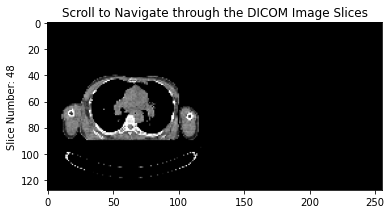

LUNG1-197


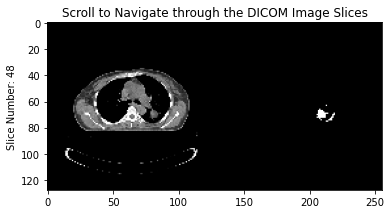

LUNG1-199


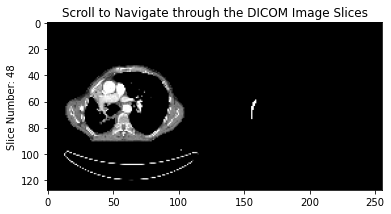

LUNG1-200


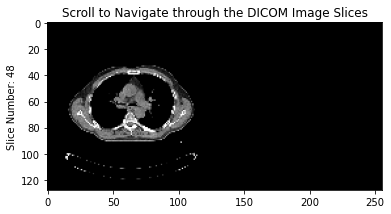

LUNG1-208


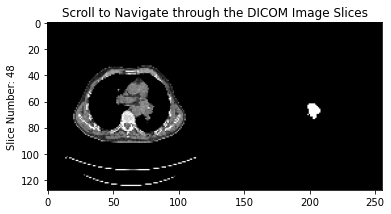

LUNG1-210


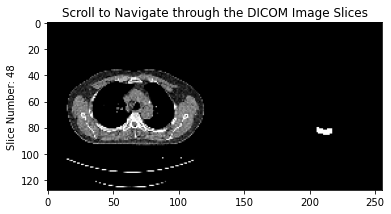

LUNG1-211


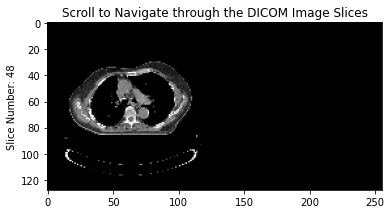

LUNG1-212


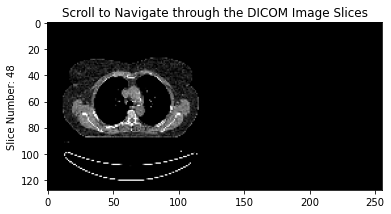

LUNG1-213


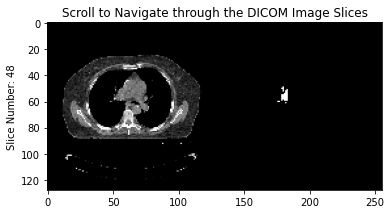

LUNG1-214


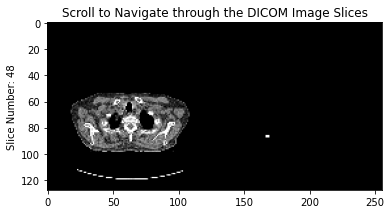

LUNG1-215


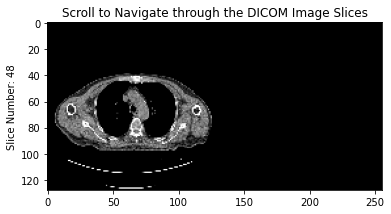

LUNG1-216


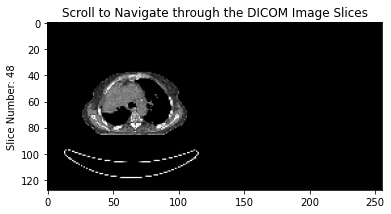

LUNG1-217


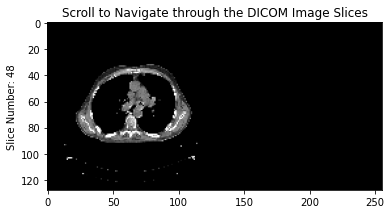

LUNG1-222


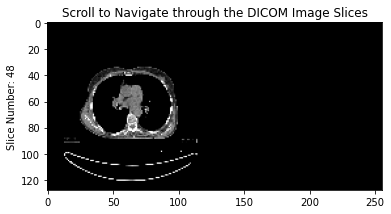

LUNG1-223


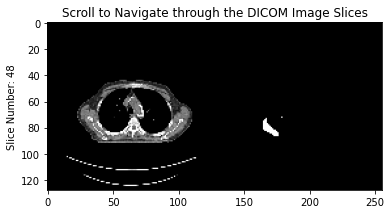

LUNG1-224


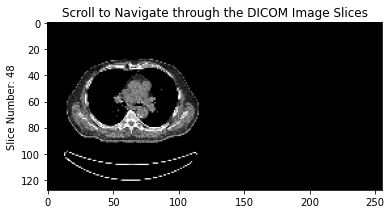

LUNG1-225


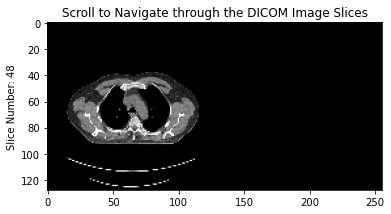

LUNG1-226


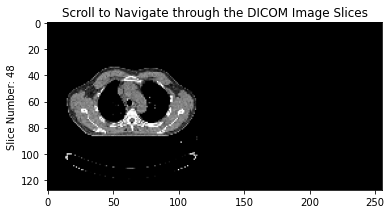

LUNG1-227


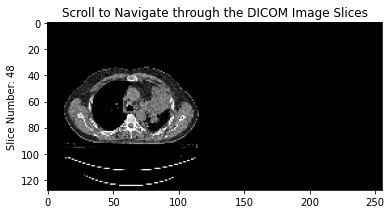

LUNG1-229


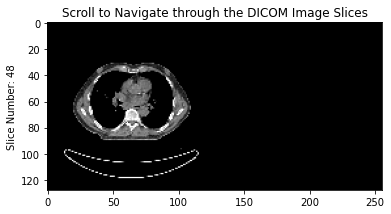

LUNG1-231


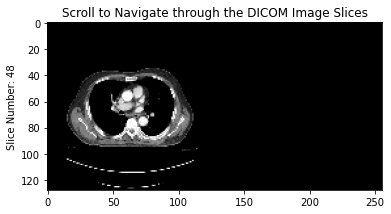

LUNG1-232


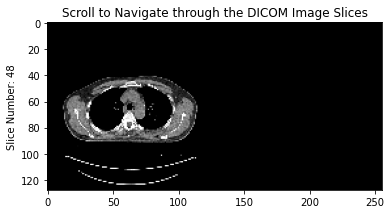

LUNG1-234


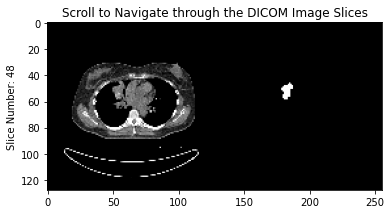

LUNG1-235


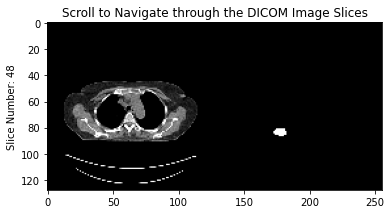

LUNG1-236


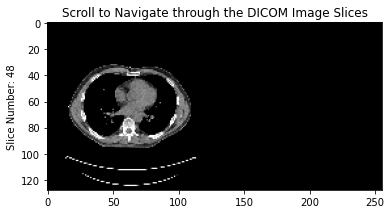

LUNG1-237


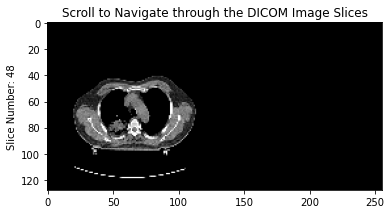

LUNG1-238


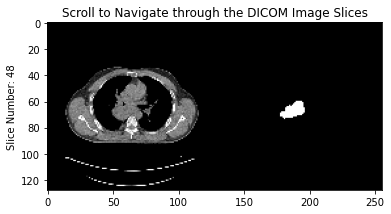

LUNG1-239


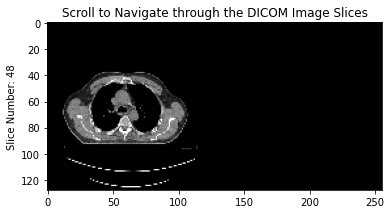

LUNG1-243


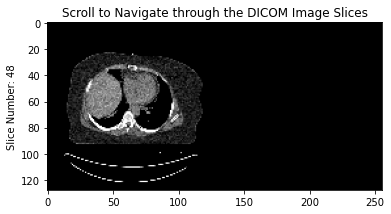

LUNG1-244


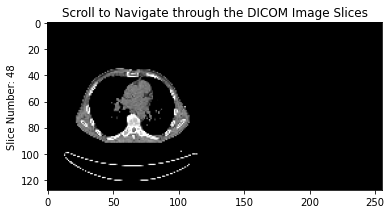

LUNG1-245


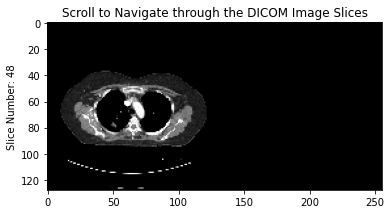

LUNG1-246


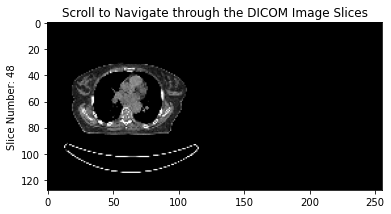

LUNG1-247


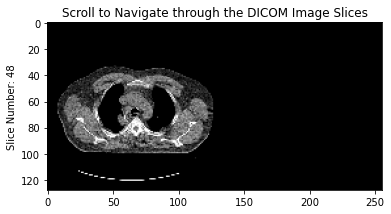

LUNG1-249


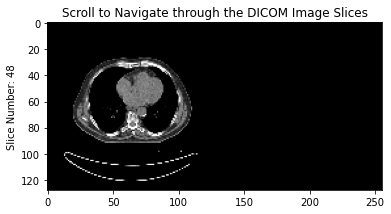

LUNG1-250


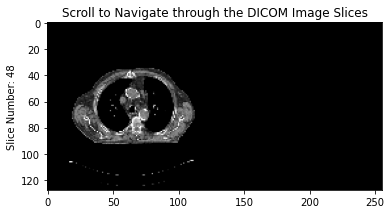

LUNG1-252


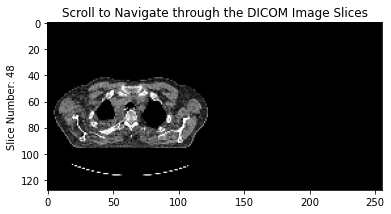

LUNG1-253


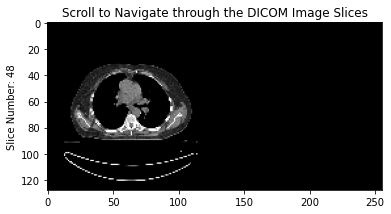

LUNG1-254


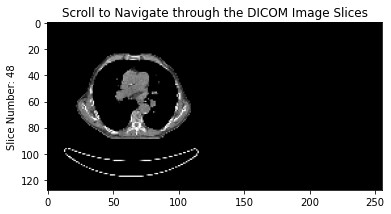

LUNG1-255


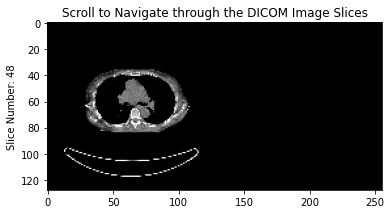

LUNG1-259


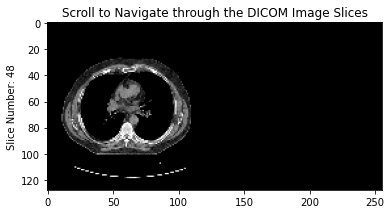

LUNG1-260


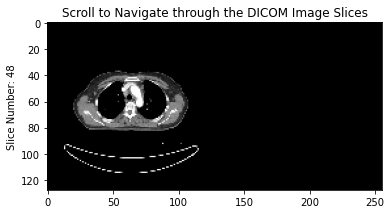

LUNG1-261


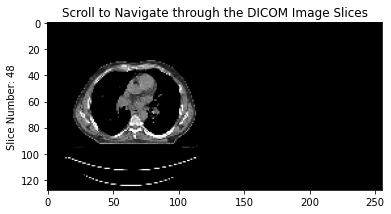

LUNG1-263


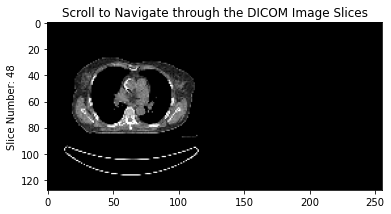

LUNG1-264


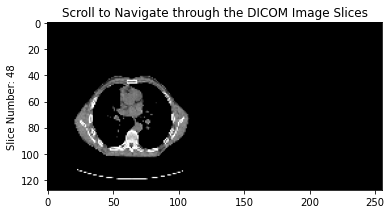

LUNG1-265


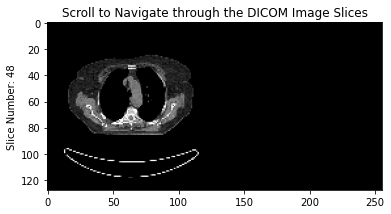

LUNG1-266


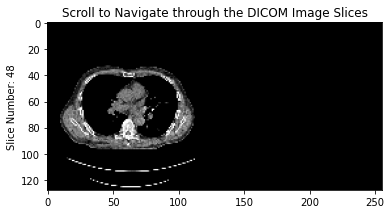

LUNG1-267


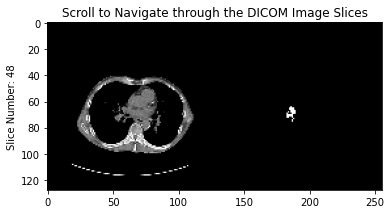

LUNG1-268


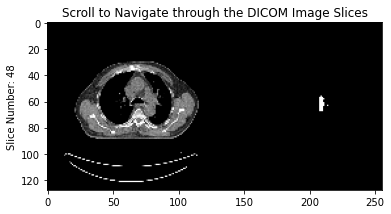

LUNG1-269


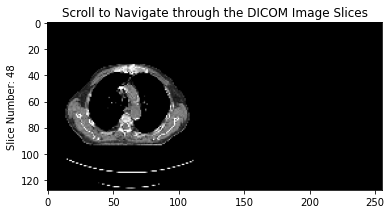

LUNG1-271


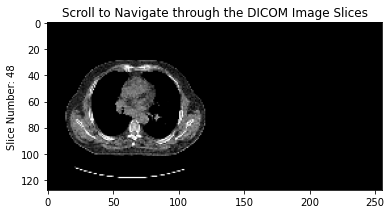

LUNG1-272


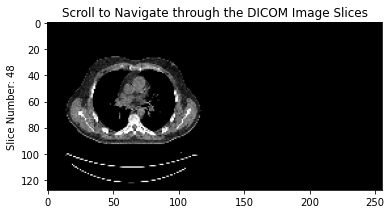

LUNG1-275


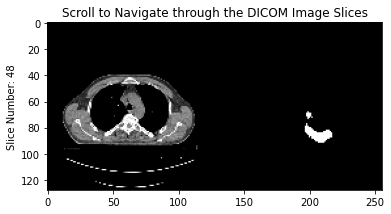

LUNG1-276


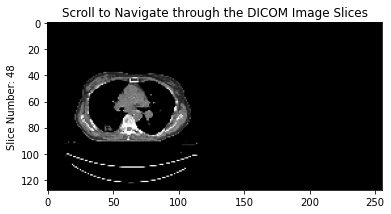

LUNG1-277


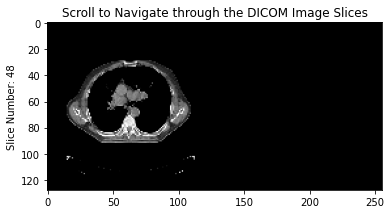

LUNG1-278


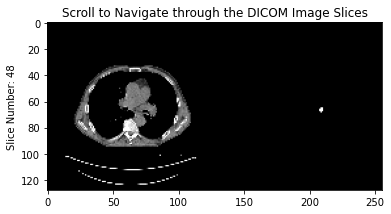

LUNG1-279


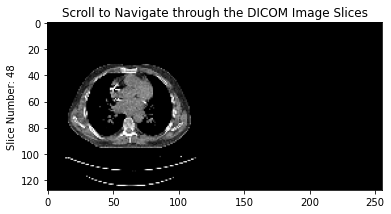

LUNG1-280


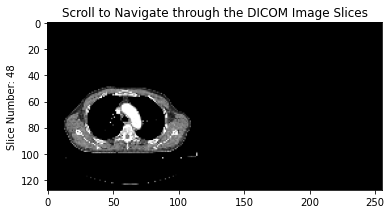

LUNG1-281


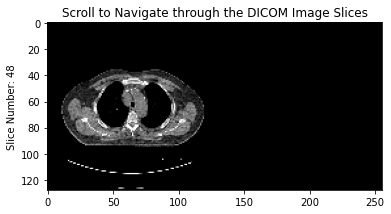

LUNG1-282


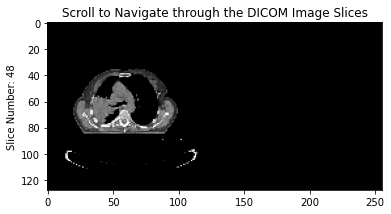

LUNG1-283


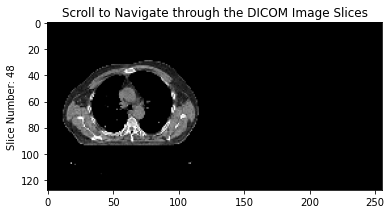

LUNG1-284


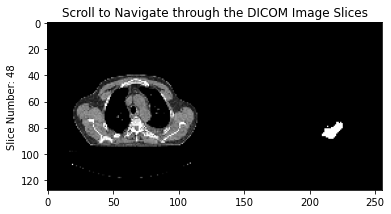

LUNG1-285


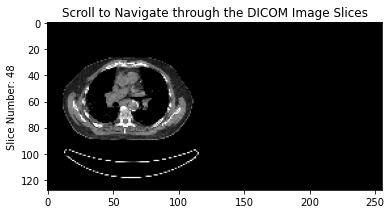

LUNG1-286


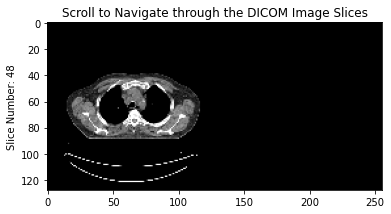

LUNG1-287


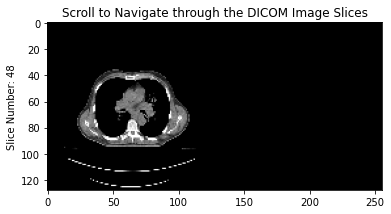

LUNG1-288


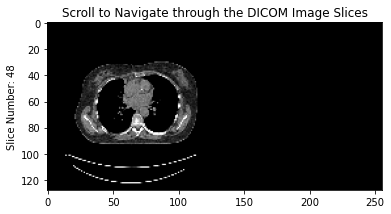

LUNG1-289


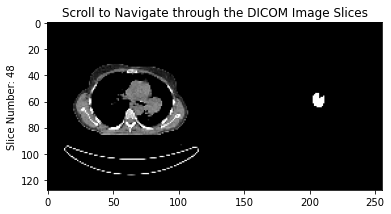

LUNG1-290


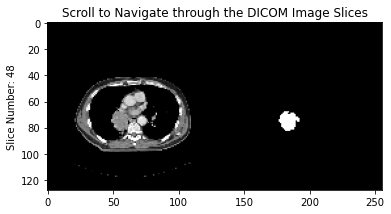

LUNG1-292


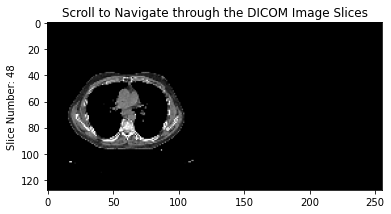

LUNG1-293


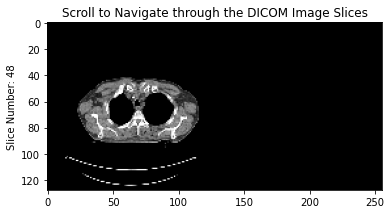

LUNG1-294


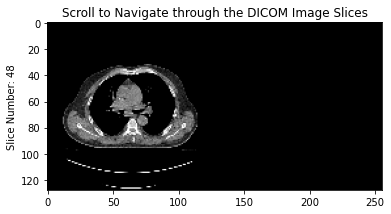

LUNG1-295


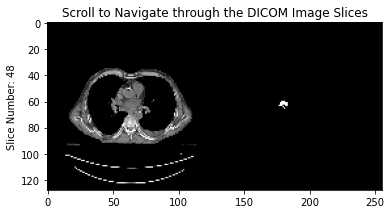

LUNG1-296


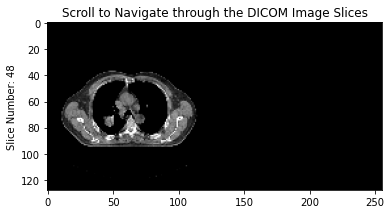

LUNG1-297


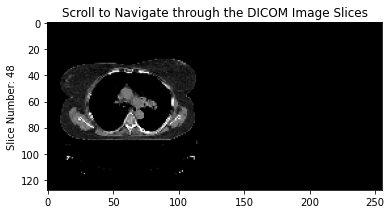

LUNG1-298


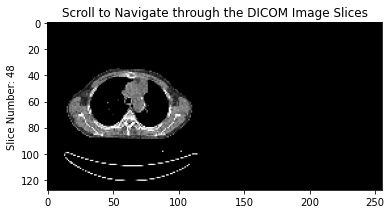

LUNG1-299


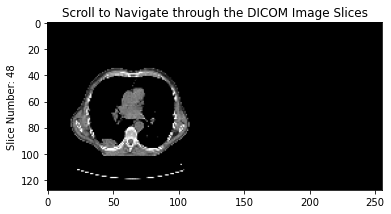

LUNG1-300


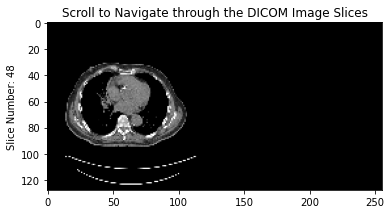

LUNG1-301


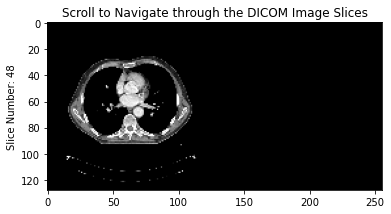

LUNG1-302


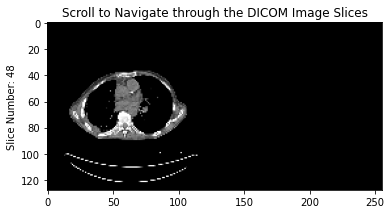

LUNG1-303


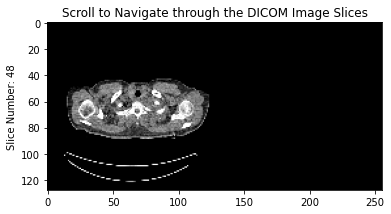

LUNG1-304


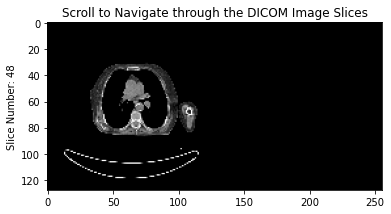

LUNG1-305


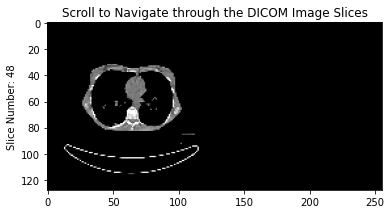

LUNG1-306


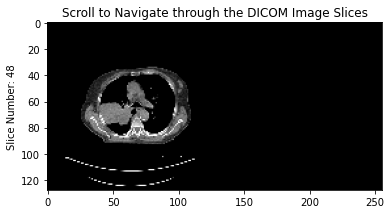

LUNG1-308


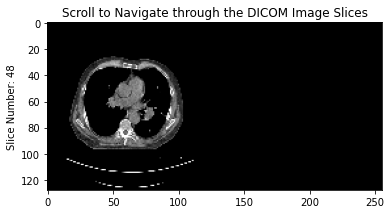

LUNG1-309


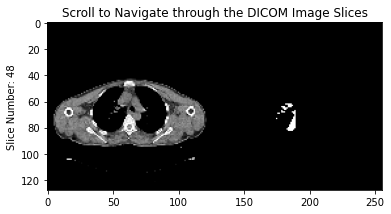

LUNG1-310


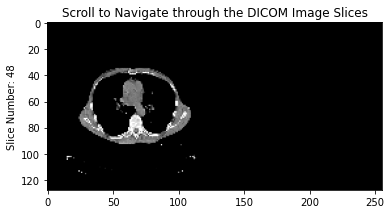

LUNG1-311


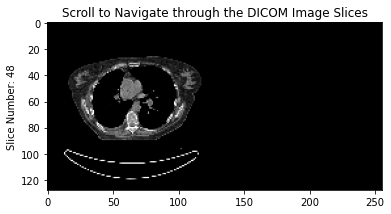

LUNG1-312


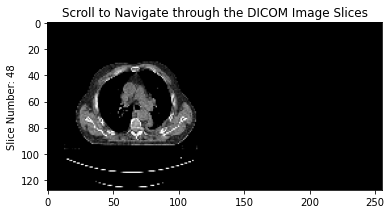

LUNG1-314


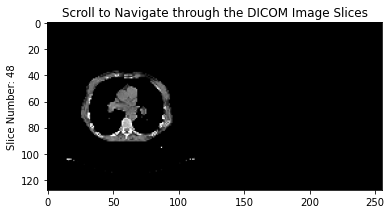

LUNG1-315


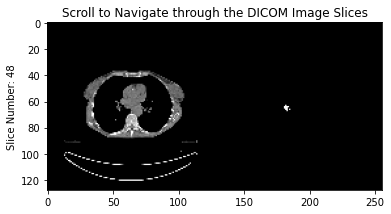

LUNG1-316


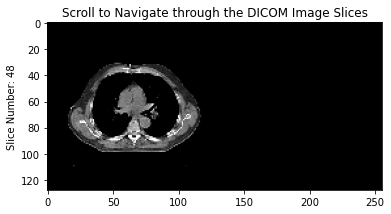

LUNG1-317


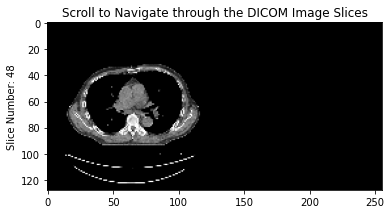

LUNG1-318


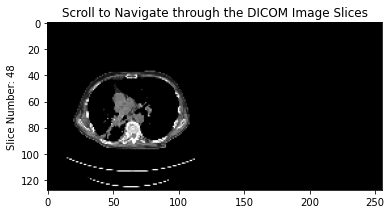

LUNG1-320


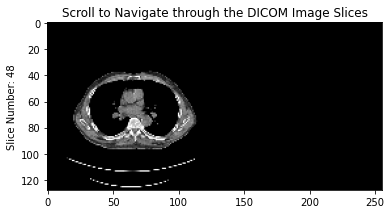

LUNG1-324


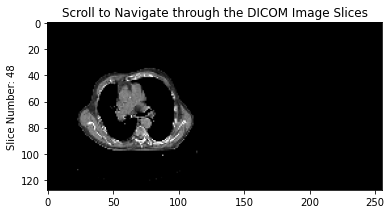

LUNG1-326


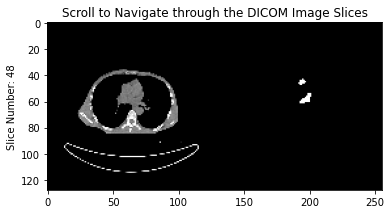

LUNG1-327


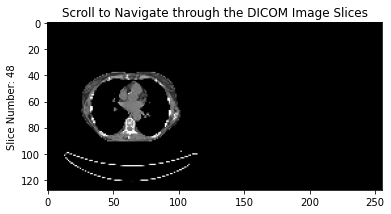

LUNG1-329


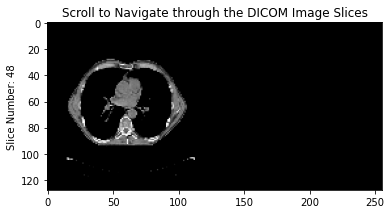

LUNG1-332


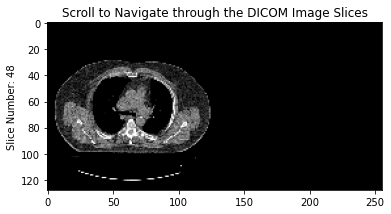

LUNG1-333


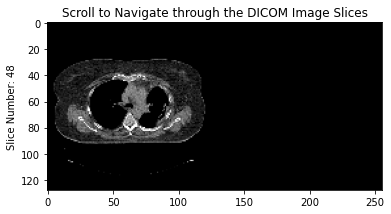

LUNG1-334


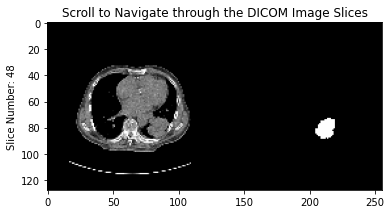

LUNG1-335


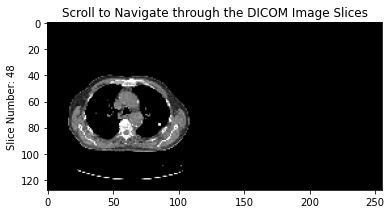

LUNG1-340


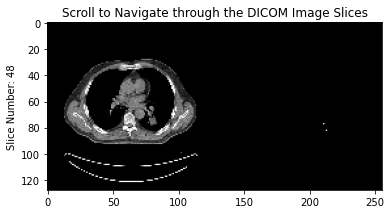

LUNG1-341


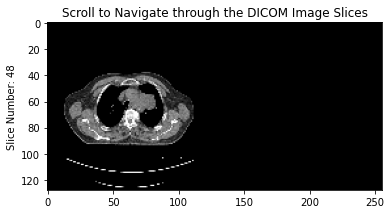

LUNG1-343


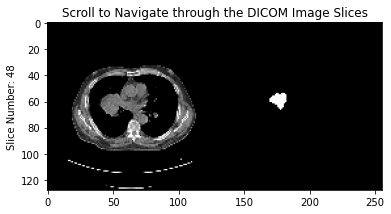

LUNG1-344


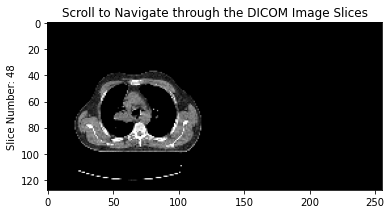

LUNG1-345


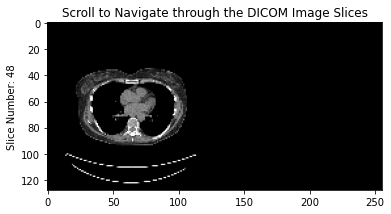

LUNG1-346


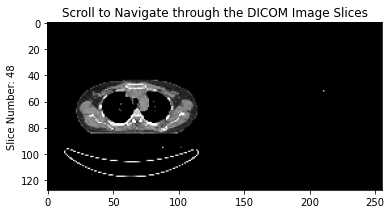

LUNG1-347


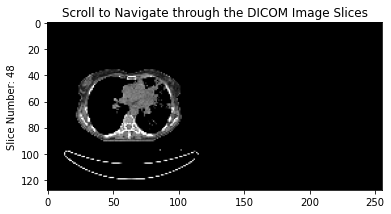

LUNG1-348


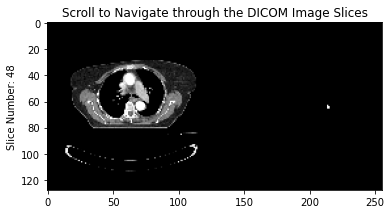

LUNG1-350


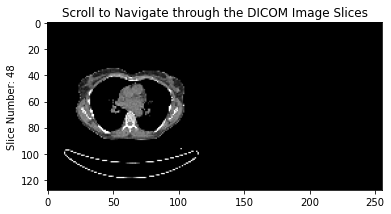

LUNG1-351


In [3]:
Path = "D:\\LungCancer\\new dataset\\NSCLC-Radiomics"
pathCTdicom = ""
pathSegdicom = ""
list_wrong_measurement = []
list_n_slice = []
size_desired = 128
n_slc_desired = 96
for dirName, subdirList, fileList in os.walk(Path):

    pathCTdicom, pathSegdicom = misc.check_path_dicom(pathCTdicom, pathSegdicom, dirName, fileList)

    if "Lung" in pathCTdicom and "Segmentation" in pathSegdicom:
#         if "LUNG1-278" not in dirName:
#             pathCTdicom, pathSegdicom = "", ""
#             continue
        if dirName[42:51] + ".npy" in os.listdir("D:/LungCancer/new dataset/dataset/all/Imgs"):
            pathCTdicom, pathSegdicom = "", ""
            #print("existed file")
            continue
#         print(pathCTdicom)
#         print(pathSegdicom)
        patient = load_scan(pathCTdicom)
        patient_pixels = misc.get_pixels_hu(patient)
        pix_spc = patient[0].PixelSpacing[0]*patient_pixels.shape[1]/size_desired
        pix_resampled, _ = misc.resample(patient_pixels, 
                                            patient[0].SliceThickness, 
                                            patient[0].PixelSpacing[0], 
                                            patient[0].PixelSpacing[1], 
                                            [pix_spc,pix_spc,pix_spc])
        
        # print("Shape before resampling\t", patient_pixels.shape)
        # print("Shape after resampling\t", pix_resampled.shape)

        # segment lung
        idx, y_min, y_max, mask = lung_segment(pix_resampled, pix_spc)
        if idx==0 or y_max-y_min > 330/pix_spc:
            pathCTdicom, pathSegdicom = "", ""
            #print(idx, y_min, y_max, dirName[42:51])
            list_wrong_measurement.append(dirName[42:51]+"-Can not detect lung")
            continue
        # read GT
        dcm = pydicom.dcmread(os.path.join(pathSegdicom,"1-1.dcm"))
        reader = pydicom_seg.SegmentReader()
        result = reader.read(dcm)
        n_len = len(result.available_segments)

        for segment_number in result.available_segments:
#             if (segment_number == 2 and n_len >=5) or (segment_number == 1 and n_len == 4) or n_len == 1:
#                 pass            
#             else:
#                 continue
            if result.dataset[0x62, 0x02][segment_number-1][0x62, 0x05].value != "Neoplasm, Primary":
                continue
            #print(result.dataset[0x62, 0x02][segment_number-1][0x62, 0x05].value)
            
            image = result.segment_image(segment_number)  
            GT_img = misc.sitk_to_np(image)
            #print(dirName[42:51], patient_pixels.shape, GT_img[0].shape)
            GT_resampled, _ = misc.resample(GT_img[0],
                                            patient[0].SliceThickness, 
                                            patient[0].PixelSpacing[0], 
                                            patient[0].PixelSpacing[1],
                                            [pix_spc, pix_spc, pix_spc])
            # GT_resampled = (GT_resampled*255.).astype(np.uint8)
            #GT_resampled = GT_resampled[::-1]
            # print("Shape before resampling\t", GT_img[0].shape)
            # print("Shape after resampling\t", GT_resampled.shape)
                    
            n_slices = len(GT_resampled)
            if abs(n_slices - pix_resampled.shape[0]) > 1:
                print(dirName[42:51], n_slices, pix_resampled.shape[0])
                list_wrong_measurement.append(dirName[42:51]+"-different shape")
            else:
                if n_slices - pix_resampled.shape[0] == 1:
                    GT_resampled = GT_resampled[:-1]
                elif n_slices - pix_resampled.shape[0] == -1:
                    pix_resampled = pix_resampled[:-1]
                assert pix_resampled.shape == GT_resampled.shape, "Dont have the shape"
                if pix_resampled.shape[0] > n_slc_desired:
                    bot_y = (y_max + y_min - n_slc_desired)//2
                    if bot_y < 0: 
                        pix_resampled = pix_resampled[0: n_slc_desired, :, :]
                        GT_resampled = GT_resampled[0: n_slc_desired, :, :]
                    elif bot_y + n_slc_desired > pix_resampled.shape[0]:
                        pix_resampled = pix_resampled[-n_slc_desired: , :, :]
                        GT_resampled = GT_resampled[-n_slc_desired: , :, :]
                    else:
                        pix_resampled = pix_resampled[bot_y: bot_y+ n_slc_desired, :, :]
                        GT_resampled = GT_resampled[bot_y: bot_y+n_slc_desired, :, :]                        

                pix_resampled = pix_resampled.astype(np.float32)
                GT_resampled = GT_resampled.astype(np.int)
                pix_resampled = misc.window_normalize_image(pix_resampled, 40, 400)

                pix_resampled, GT_resampled = misc.padding_image(pix_resampled, GT_resampled, n_slc_desired)

                GT_resampled[pix_resampled == 0] = 0

                #print(dirName[42:51], pix_resampled.shape, GT_resampled.shape)
                np.save("D:/LungCancer/new dataset/dataset/all/Imgs/" + dirName[42:51]+ ".npy", pix_resampled)
                np.save("D:/LungCancer/new dataset/dataset/all/GT/" + dirName[42:51]+ ".npy", GT_resampled)
                
                misc.imshow_slices(np.dstack((pix_resampled, GT_resampled)))
                print(dirName[42:51])
        # reset path
        pathCTdicom, pathSegdicom = "", ""



In [4]:
with open("note_lung_1.txt", "w") as f:
    for ele in list_wrong_measurement:
        f.write(ele+'\n')
    f.close()